## Prerequisites

This is a simple inference example using Imagenet MobilenetV1 model. To run this examples, you must install the required packages and setup Python environment by following the guides:
* [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/v0.5.0/ko/software/installation.html)
* [Setting up a Python Environment](https://furiosa-ai.github.io/docs/v0.5.0/ko/software/python-sdk.html#python)

Then, please install the following python packages:
```sh
pip install furiosa-sdk matplotlib pillow
```
Otherwise, you can run the following command to install all dependent packages for notebook examples:
```sh
pip install -r examples/notebooks/requirements.txt
```

Then, you are now ready to run the following examples.

## Checking environment
First, let's check your NPU device is ready.

In [1]:
from PIL import ImageDraw
from PIL import Image

# Import Furiosa SDK
from furiosa.runtime import session

# Import helper for image classlification
from helper import load_labels, image_path, show_image
from helper.mobilenet_ssd import *

import time

libnpu.so --- v2.0, built @ fe1fca3


# Image Classification

In [2]:
# Load and compile an imagenet model for NPU

model_path = "models/imagenet_224x224_mobilenet_v1_uint8_quantization-aware-trained_dm_1.0_without_softmax.tflite"
start_time = time.time()
classification = session.create(model_path)
print('Compilation took {:.2f} secs'.format(time.time() - start_time))

Saving the compilation log into /home/jovyan/.local/state/furiosa/logs/compile-20211213233248-pswpso.log
Using furiosa-compiler 0.5.0 (rev: 407c0c51f-modified built at 2021-11-22 20:18:37)
2021-12-13T23:32:48.525081Z  INFO Npu (npu4pe0-1) is being initialized
2021-12-13T23:32:48.526650Z  INFO NuxInner create with pes: [PeId(0)]


[1/6] 🔍   Compiling from tflite to dfg
Done in 0.2009424s
[2/6] 🔍   Compiling from dfg to ldfg


2021-12-13T23:34:29.387204Z  INFO [Profiler] Program binary notification has been arrived. Cleanup current profile queue data
Compilation took 100.99 secs


Done in 100.60988s
[3/6] 🔍   Compiling from ldfg to cdfg
Done in 0.000698632s
[4/6] 🔍   Compiling from cdfg to gir
Done in 0.006802399s
[5/6] 🔍   Compiling from gir to lir
Done in 0.001900327s
[6/6] 🔍   Compiling from lir to enf
Done in 0.015689703s
✨  Finished in 100.83643s


In [3]:
# Print out the summary of the model

classification.print_summary()

Inputs:
{0: TensorDesc(shape=(1, 224, 224, 3), dtype=UINT8, format=NHWC, size=150528, len=150528)}
Outputs:
{0: TensorDesc(shape=(1, 1, 1, 1001), dtype=UINT8, format=NHWC, size=1001, len=1001)}


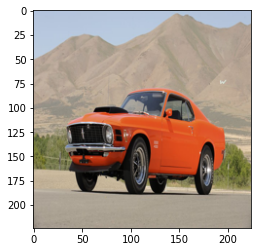

In [4]:
# Get the shape of the model input and resize the input image 
# according to the input tensor shape of the model.

_, height, width, channel = classification.input(0).shape
image = Image.open(image_path('car.jpg')).convert('RGB').resize((width, height))
show_image(image)

In [5]:
# Fill a numpy ndarray with the resized image

data = np.zeros((width, height, channel), np.uint8)
data[:width, :height, :channel] = image
data = np.reshape(data, (1, width, height, channel))

In [6]:
# Run an inference with the numpy ndarray

start_time = time.time()
outputs = classification.run(data)
print('Elapsed {:.2f} secs'.format(time.time() - start_time))

Elapsed 0.00 secs


In [7]:
# Check out the output tensor shape

outputs

{0: Tensor(shape=(1, 1, 1, 1001), dtype=UINT8)}

In [8]:
# Post processing: transform the tensor outputs to human readable data

classified = np.squeeze(outputs[0].numpy())
imagenet_labels = load_labels('ImageNetLabels.txt')
Class = collections.namedtuple('Class', ['id', 'score'])
objects = []
for idx, n in np.ndenumerate(classified):
    objects.append(Class(idx[0], n))
    
objects.sort(key=lambda x: x[1], reverse=True)
print("[Top 5 scores:]")
for object in objects[:5]:
    print("{}: {}".format(imagenet_labels[object.id], object.score))

[Top 5 scores:]
sports car: 155
pickup: 152
car wheel: 148
convertible: 147
jeep: 142


In [9]:
classification.close()

2021-12-13T23:34:29.713151Z  INFO [Profiler] Received a termination signal.
2021-12-13T23:34:29.714755Z  INFO session has been destroyed
